# Coding Exercise 1: Simulating SDEs
In this exercise, we will learn how to numerically simulate SDEs, and in particular the Langevin diffusion.

In [32]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from abc import ABC, abstractmethod
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Section 1: specify a distribution
To distinguish all kinds of distributions, we specify
- whether it has an explicit density
- whether we can sample from it

This is a bit cumbersome in practice, but helps us to organize the code and teach concepts

In [33]:
class Density(ABC):
    @abstractmethod
    def log_prob(self, x):
        """
        Returns the log density at x
        """
        pass

class Sampleable(ABC):
    @abstractmethod
    def sample(self, num_samples: int):
        """
        Return num_samples samples from the distribution
        """
        pass

In [34]:
# examples of distributions
class Gaussian(torch.nn.Module, Density, Sampleable):
    """
    Gaussian with mean and covariance
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        super().__init__()
        self.mean = mean
        self.cov = cov
        self.inv_cov = torch.linalg.inv(cov)
        self.log_det_cov = torch.logdet(cov)
        self.dim = mean.shape[0]

    def log_prob(self, x):
        return torch.distributions.MultivariateNormal(self.mean, self.cov).log_prob(x).view(-1, 1)

    def sample(self, num_samples: int):
        # use built-in multivariate normal distribution to sample
        return torch.distributions.MultivariateNormal(self.mean, self.cov).sample((num_samples,))

class MixtureOfGaussians(torch.nn.Module, Density, Sampleable):
    """
    Mixture of Gaussians with given means, covariances, and weights
    """
    def __init__(self, means: torch.Tensor, covs: torch.Tensor, weights: torch.Tensor):
        super().__init__()
        self.means = means
        self.covs = covs
        self.weights = weights / weights.sum()  # normalize weights
        self.num_components = means.shape[0]
        self.dim = means.shape[1]
        self.components = [Gaussian(means[i], covs[i]) for i in range(self.num_components)]

    def log_prob(self, x):
        log_probs = torch.stack([comp.log_prob(x) + torch.log(weight) for comp, weight in zip(self.components, self.weights)], dim=0)
        return torch.logsumexp(log_probs, dim=0)

    def sample(self, num_samples: int):
        samples = []
        for _ in range(num_samples):
            component = np.random.choice(self.num_components, p=self.weights.cpu().numpy())
            samples.append(self.components[component].sample(1))
        return torch.cat(samples, dim=0)
    
    @classmethod
    def random_2D(
        cls, num_components: int, mean_range: float = 10.0, cov_range: float = 5.0
    ) -> "MixtureOfGaussians":
        means = torch.rand(num_components, 2) * mean_range - mean_range / 2
        covs = torch.stack([torch.diag(torch.rand(2) * cov_range + 0.5) for _ in range(num_components)], dim=0)
        weights = torch.rand(num_components)
        return cls(means, covs, weights)
    
    @classmethod
    def circle_2D(
        cls, num_components: int, radius: float = 5.0, cov_range: float = 1.0
    ) -> "MixtureOfGaussians":
        """
        Create a mixture of Gaussians arranged in a circle. The means are placed evenly around the circle with the given radius, and the covariances are random diagonal matrices with values in the given range.
        """
        angles = torch.linspace(0, 2 * np.pi, num_components+1)[:-1] # exclude the last point which is the same as the first
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * radius
        covs = torch.stack([torch.diag(torch.rand(2) * cov_range + 0.5) for _ in range(num_components)], dim=0)
        weights = torch.rand(num_components)
        return cls(means, covs, weights)

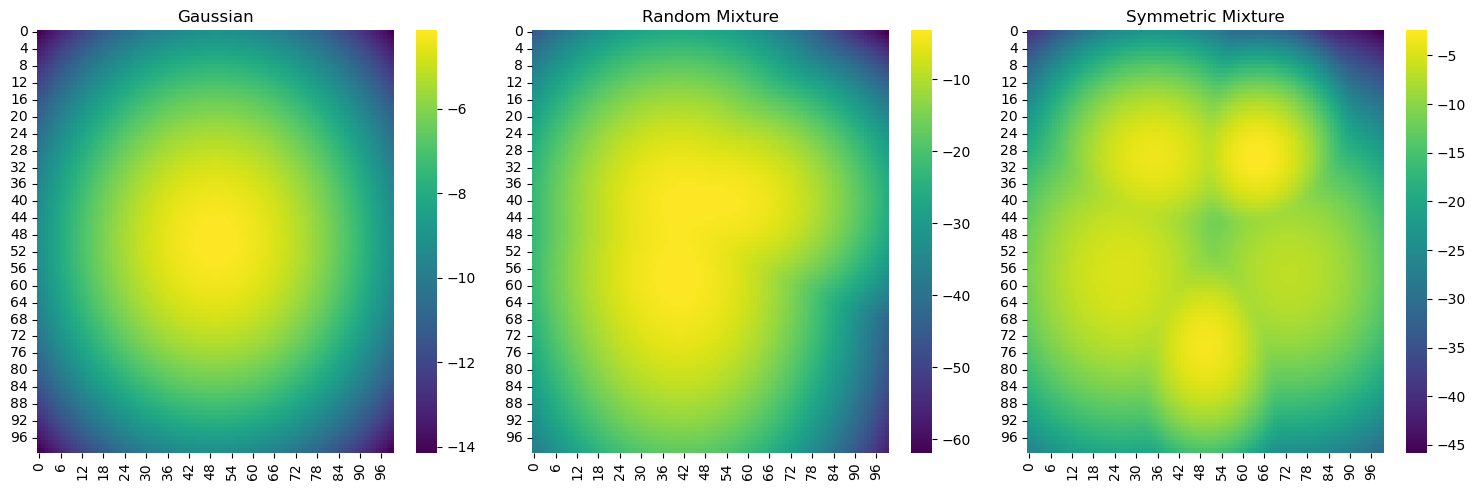

In [35]:
# Visualize densities
densities = {
    "Gaussian": Gaussian(mean=torch.zeros(2), cov=10 * torch.eye(2)).to(device),
    "Random Mixture": MixtureOfGaussians.random_2D(num_components=5, mean_range=5.0, cov_range=2.0).to(device),
    "Symmetric Mixture": MixtureOfGaussians.circle_2D(num_components=5, radius=5.0, cov_range=2.0).to(device),
}

fig, axies = plt.subplots(1, len(densities), figsize=(15, 5))
scale = 10
bins = 100

for ax, (name, density) in zip(axies, densities.items()):
    x = torch.linspace(-scale, scale, bins)
    y = torch.linspace(-scale, scale, bins)
    X, Y = torch.meshgrid(x, y)
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
    with torch.no_grad():
        log_probs = density.log_prob(grid).cpu().numpy().reshape(bins, bins)
    sns.heatmap(log_probs, ax=ax, cmap="viridis")
    ax.set_title(name)
plt.tight_layout()
plt.show()

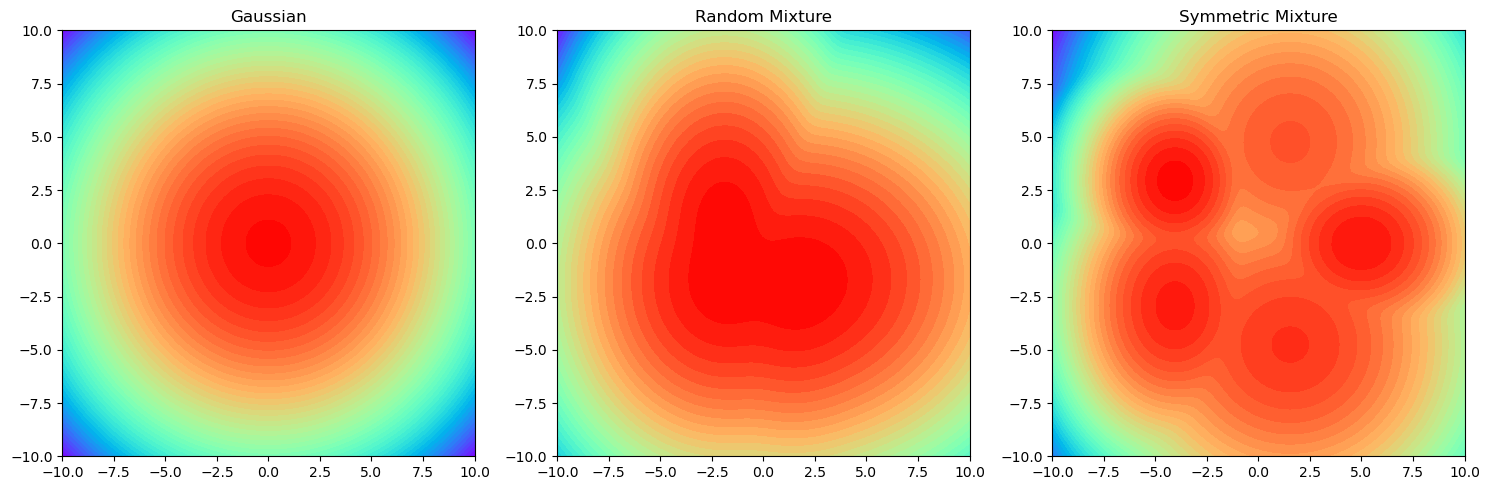

In [36]:
# same but contour plot
fig, axies = plt.subplots(1, len(densities), figsize=(15, 5))
scale = 10
bins = 100

for ax, (name, density) in zip(axies, densities.items()):
    x = torch.linspace(-scale, scale, bins)
    y = torch.linspace(-scale, scale, bins)
    X, Y = torch.meshgrid(x, y)
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
    with torch.no_grad():
        log_probs = density.log_prob(grid).cpu().numpy().reshape(bins, bins)
    ax.contourf(X.cpu(), Y.cpu(), log_probs, levels=50, cmap="rainbow")
    ax.set_title(name)
plt.tight_layout()
plt.show()

## Section 2: Numerical methods to simulate SDEs
We are given a stochastic differential equation of the form
$$
d X_t = a(X_t, t) dt + \sigma_t d W_t
$$
where 
$$
a: \mathbb{R}^n \times [0, T] \to \mathbb{R}^n,
$$
$\sigma_t$ is the diffusion term and $W_t$ is standard Brownian motion.


## Section 3: Simulate Langevin diffusion with Eura-Maruyama discretization


In [37]:
grid.shape

torch.Size([10000, 2])